# Categorical VAE with Gumbel-Softmax

Partial implementation of the paper [Categorical Reparameterization with Gumbel-Softmax](https://arxiv.org/abs/1611.01144) 

A categorical VAE with discrete latent variables. Tensorflow version is 0.10.0.

# 1. Imports and Helper Functions

In [1]:
import tensorflow as tf
from abstract_network import *
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
slim=tf.contrib.slim
Bernoulli = tf.contrib.distributions.Bernoulli
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
def sample_gumbel(shape, eps=1e-20): 
  """Sample from Gumbel(0, 1)"""
  U = tf.random_uniform(shape,minval=0,maxval=1)
  return -tf.log(-tf.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature): 
  """ Draw a sample from the Gumbel-Softmax distribution"""
  y = logits + sample_gumbel(tf.shape(logits))
  return tf.nn.softmax( y / temperature)

def gumbel_softmax(logits, temperature, hard=False):
  """Sample from the Gumbel-Softmax distribution and optionally discretize.
  Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
  Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
  """
  y = gumbel_softmax_sample(logits, temperature)
  if hard:
    k = tf.shape(logits)[-1]
    #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
    y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keep_dims=True)),y.dtype)
    y = tf.stop_gradient(y_hard - y) + y
  return y

In [3]:
K=2 # number of classes
N=30 # number of categorical distributions

In [4]:
# input image x (shape=(batch_size,784))
x = tf.placeholder(tf.float32, [None,784])

# x = tf.reshape(x, [None, 28, 28, 1])
# variational posterior q(y|x), i.e. the encoder (shape=(batch_size,200))

# Encoder and decoder use the DC-GAN architecture
def encoder(xc):
    with tf.variable_scope('i_net'):
        xc = tf.reshape(x, [-1, 28, 28, 1])
        conv1 = conv2d_lrelu(xc, 64, 4, 2)
        conv2 = conv2d_lrelu(conv1, 128, 4, 2)
        conv2 = tf.reshape(conv2, [-1, np.prod(conv2.get_shape().as_list()[1:])])
        fc1 = fc_lrelu(conv2, 1024)
        # z_logits = tf.contrib.layers.fully_connected(fc1, z_dim, activation_fn=tf.identity)
        return fc1
    
net = encoder(x)
# unnormalized logits for N separate K-categorical distributions (shape=(batch_size*N,K))
logits_y = tf.reshape(slim.fully_connected(net,K*N,activation_fn=None),[-1,K])
q_y = tf.nn.softmax(logits_y)
log_q_y = tf.log(q_y+1e-20)
# temperature
tau = tf.Variable(5.0,name="temperature")
# sample and reshape back (shape=(batch_size,N,K))
# set hard=True for ST Gumbel-Softmax
y = tf.reshape(gumbel_softmax(logits_y,tau,hard=True),[-1,N,K])
y = y[:, :, 0]
# generative model p(x|y), i.e. the decoder (shape=(batch_size,200))

def generator(z, reuse=False):
    with tf.variable_scope('g_net') as vs:
        if reuse:
            vs.reuse_variables()
        fc = fc_relu(z, 1024)
        fc = fc_relu(fc, 7*7*128)
        fc = tf.reshape(fc, tf.stack([tf.shape(fc)[0], 7, 7, 128]))
        conv = conv2d_t_relu(fc, 64, 4, 2)
        conv = conv2d_t_relu(conv, 64, 4, 1)
        output = tf.contrib.layers.convolution2d_transpose(conv, 1, 4, 2, activation_fn=tf.sigmoid)
        output = tf.reshape(output, [-1, 784])
        return output
    
xr = generator(y)
# (shape=(batch_size,784))
# p_x = Bernoulli(logits=logits_x)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
# loss and train ops
kl_tmp = q_y*(log_q_y-tf.log(1.0/K))
KL = tf.reduce_sum(kl_tmp,[1,2])
elbo=-100 * tf.reduce_sum(tf.abs(x - xr),1) - KL

In [6]:
loss=tf.reduce_mean(-elbo)
lr=tf.constant(0.001)
train_op=tf.train.AdamOptimizer(learning_rate=lr).minimize(loss,var_list=slim.get_model_variables())
init_op=tf.global_variables_initializer()

# 3. Train

In [7]:
# get data
data = input_data.read_data_sets('/tmp/', one_hot=True).train 

Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


In [8]:
BATCH_SIZE=100
NUM_ITERS=30000
tau0=1.0 # initial temperature
np_temp=tau0
np_lr=0.001
ANNEAL_RATE=0.00003
MIN_TEMP=0.5

In [9]:
dat=[]
sess=tf.InteractiveSession()
sess.run(init_op)
for i in range(1,NUM_ITERS):
    np_x,np_y=data.next_batch(BATCH_SIZE)
    # np_x = np.reshape(np_x, [-1, 28, 28, 1])
    _,np_loss=sess.run([train_op,loss],{
      x:np_x,
      tau:np_temp,
      lr:np_lr
    })
    if i % 100 == 1:
        dat.append([i,np_temp,np_loss])
    if i % 1000 == 1:
        np_temp=np.maximum(tau0*np.exp(-ANNEAL_RATE*i),MIN_TEMP)
        np_lr*=0.9
    if i % 5000 == 1:
        print('Step %d, ELBO: %0.3f' % (i,-np_loss))

Step 1, ELBO: -37124.102
Step 5001, ELBO: -9900.077
Step 10001, ELBO: -10317.249
Step 15001, ELBO: -10417.691
Step 20001, ELBO: -9636.900
Step 25001, ELBO: -9922.332


# 4. Plot Training Curves

In [10]:
dat=np.array(dat).T

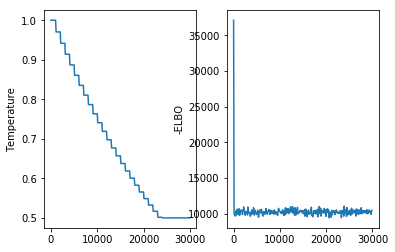

In [11]:
f,axarr=plt.subplots(1,2)
axarr[0].plot(dat[0],dat[1])
axarr[0].set_ylabel('Temperature')
axarr[1].plot(dat[0],dat[2])
axarr[1].set_ylabel('-ELBO')

# 5. Unconditional Generation

This consists of sampling from the prior $p_\theta(y)$ and passing it through the generative model.

In [12]:
M=100*N
np_y = np.zeros((M,K))
np_y[range(M),np.random.choice(K,M)] = 1
np_y = np.reshape(np_y,[100,N,K])

In [13]:
np_x= sess.run(xr,{y:np_y[:, :, 0]})

In [14]:
np_y = np_y.reshape((10,10,N,K))
np_y = np.concatenate(np.split(np_y,10,axis=0),axis=3)
np_y = np.concatenate(np.split(np_y,10,axis=1),axis=2)
y_img = np.squeeze(np_y)

In [15]:
np_x = np_x.reshape((10,10,28,28))
# split into 10 (1,10,28,28) images, concat along columns -> 1,10,28,280
np_x = np.concatenate(np.split(np_x,10,axis=0),axis=3)
# split into 10 (1,1,28,280) images, concat along rows -> 1,1,280,280
np_x = np.concatenate(np.split(np_x,10,axis=1),axis=2)
x_img = np.squeeze(np_x)

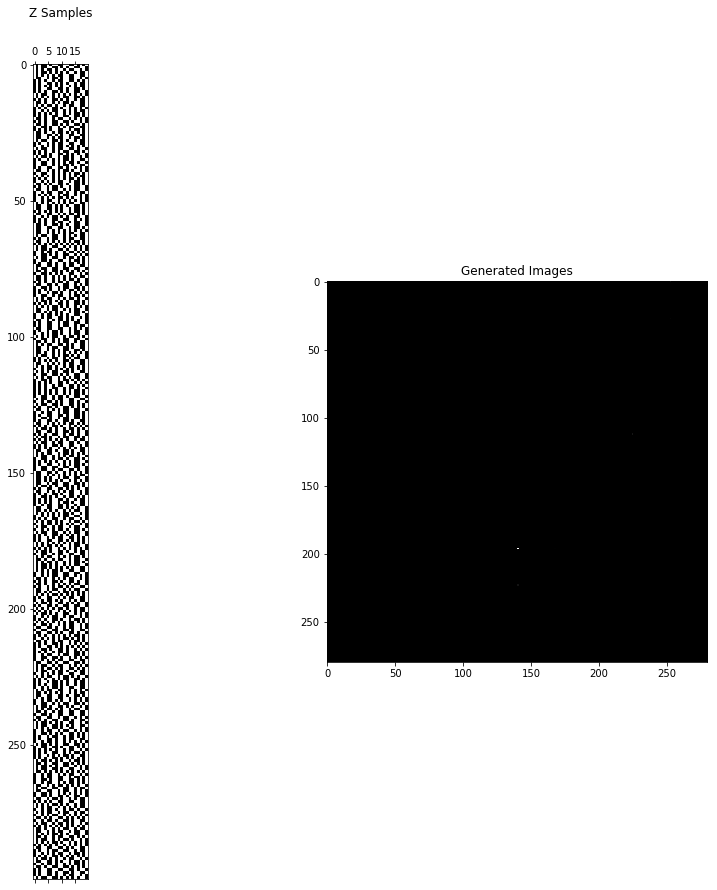

In [16]:
f,axarr=plt.subplots(1,2,figsize=(15,15))
# samples
axarr[0].matshow(y_img,cmap=plt.cm.gray)
axarr[0].set_title('Z Samples')
# reconstruction
axarr[1].imshow(x_img,cmap=plt.cm.gray,interpolation='none')
axarr[1].set_title('Generated Images')